In [1]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
import bitstring
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector

from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

from qiskit.circuit.library import UnitaryGate

In [2]:
matrix_h = ([[2**(-0.5),2**(-0.5)],[2**(-0.5),-2**(-0.5)]])
h_ideal = UnitaryGate(matrix_h)

matrix_cx = ([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])
cx_ideal = UnitaryGate(matrix_cx)       #Erst Target, dann Control Qubit!!

matrix_x = ([[0,1],[1,0]])
x_ideal = UnitaryGate(matrix_x)

matrix_z = ([[1,0],[0,-1]])
z_ideal = UnitaryGate(matrix_z)

In [26]:
def rot_surf_code(n: int) -> QuantumCircuit:              #1st anc = third last qubit = syndrome/parity measurement qubit, 2nd anc = sec last qubit = magic state for S Gate, 3rd anc = last qubit = magic state for T-Gate
    qr = QuantumRegister(9*n+1, "q")
    cbit = ClassicalRegister(4,"c")
    qc = QuantumCircuit(qr,cbit)
    list = []
    for i in range(0, 9*n):
        list.append("{:c}".format(i))
    list = qr
    for i in range(n):
        qc.h(list[9*i+1])
        qc.h(list[9*i+3])
        qc.h(list[9*i+5])
        qc.h(list[9*i+7])

        qc.cx(list[9*i+1],list[9*i])
        qc.cx(list[9*i+5],list[9*i+4])
        qc.cx(list[9*i+7],list[9*i+8])

        qc.cx(list[9*i+5],list[9*i+2])

        qc.cx(list[9*i+3],list[9*i+4])
        qc.cx(list[9*i+2],list[9*i+1])

        qc.cx(list[9*i+3],list[9*i+6])

        qc.cx(list[9*i+6],list[9*i+7])
    return qc

def X_L(circuit: QuantumCircuit, hadamard = False, n=0):            #n muss bei 0 anfangen, also z.B. man hat 3 Circuits und will X_L auf den ersten anwenden ---> n = 0 !!!
    if hadamard:
        circuit.x(9*n+3)
        circuit.x(9*n+4)
        circuit.x(9*n+5)
    else:
        circuit.x(9*n+1)
        circuit.x(9*n+4)
        circuit.x(9*n+7)

def Z_L(circuit: QuantumCircuit, hadamard = False, n=0):            #n muss bei 0 anfangen, also z.B. man hat 3 Circuits und will Z_L auf den ersten anwenden ---> n = 0 !!!
    if hadamard:
        circuit.z(9*n+1)
        circuit.z(9*n+4)
        circuit.z(9*n+7)
    else:
        circuit.z(9*n+3)
        circuit.z(9*n+4)
        circuit.z(9*n+5)

def H_L(circuit: QuantumCircuit, pos=0):              #H-Gates auf EINEN Circuit, wieder erster Circuit --> n = 0, zweiter Circuit --> n = 1 , usw.
    for i in range(9):
        circuit.h(9*pos+i)

def S_L(qc: QuantumCircuit, had = False, pos=0):
    anc = qc.num_qubits - 1
    qc.reset(anc)

    #qc.h(magic_S)
    qc.append(h_ideal,[anc])
    qc.s(anc)

    if had == False:
        qc.cx(3+9*pos)
        qc.cx(4+9*pos)
        qc.cx(5+9*pos)        
    else:
        qc.cx(1+9*pos)
        qc.cx(4+9*pos)
        qc.cx(7+9*pos)  

    qc.measure(anc, 0)

    if had == False:
        with qc.if_test((0,1)):
            qc.z(3+9*pos)
            qc.z(4+9*pos)
            qc.z(5+9*pos)
    else:
        with qc.if_test((0,1)):
            qc.z(1+9*pos)
            qc.z(4+9*pos)
            qc.z(7+9*pos)

def adj_S_L(qc: QuantumCircuit, had = False, pos=0):
    anc = qc.num_qubits - 1
    qc.reset(anc)

    #qc.h(magic_S)
    qc.append(h_ideal,[anc])
    qc.sdg(anc)

    if had == False:
        qc.cx(3+9*pos)
        qc.cx(4+9*pos)
        qc.cx(5+9*pos)        
    else:
        qc.cx(1+9*pos)
        qc.cx(4+9*pos)
        qc.cx(7+9*pos)  

    qc.measure(anc, 0)

    if had == False:
        with qc.if_test((0,1)):
            qc.z(3+9*pos)
            qc.z(4+9*pos)
            qc.z(5+9*pos)
    else:
        with qc.if_test((0,1)):
            qc.z(1+9*pos)
            qc.z(4+9*pos)
            qc.z(7+9*pos)

def Z_parity(circuit: QuantumCircuit, hadamard = False, pos = 0):
    qc = circuit
    ancilla = qc.num_qubits - 1
    if hadamard:
        qc.cx(1+9*pos,ancilla)
        qc.cx(4+9*pos,ancilla)
        qc.cx(7+9*pos,ancilla)
    else:
        qc.cx(3+9*pos,ancilla)
        qc.cx(4+9*pos,ancilla)
        qc.cx(5+9*pos,ancilla)

def X_parity(circuit: QuantumCircuit, hadamard = False, pos = 0):
    qc = circuit
    ancilla = qc.num_qubits - 1
    #qc.h(ancilla)
    if hadamard:
        qc.cx(ancilla,3+9*pos)
        qc.cx(ancilla,4+9*pos)
        qc.cx(ancilla,5+9*pos)
    else:
        qc.cx(ancilla,1+9*pos)
        qc.cx(ancilla,4+9*pos)
        qc.cx(ancilla,7+9*pos)
    #qc.h(ancilla)
    
def T_L(qc: QuantumCircuit, had = False, pos = 0):
    anc = qc.num_qubits - 1
    qc.reset(anc)

    #qc.h(magic_S)
    qc.append(h_ideal,[anc])
    qc.t(anc)

    if had == False:
        qc.cx(3+9*pos)
        qc.cx(4+9*pos)
        qc.cx(5+9*pos)        
    else:
        qc.cx(1+9*pos)
        qc.cx(4+9*pos)
        qc.cx(7+9*pos)  

    qc.measure(anc, 0)

    if had == False:
        with qc.if_test((0,1)):
            qc.reset(anc)
            qc.append(h_ideal,[anc])
            qc.s(anc)
            qc.cx(3+9*pos)
            qc.cx(4+9*pos)
            qc.cx(5+9*pos) 
            qc.measure(anc, 0)
            with qc.if_test((0,1)):
                qc.z(3+9*pos)
                qc.z(4+9*pos)
                qc.z(5+9*pos)
    else:
        with qc.if_test((0,1)):
            qc.reset(anc)
            qc.append(h_ideal,[anc])
            qc.s(anc)
            qc.cx(1+9*pos)
            qc.cx(4+9*pos)
            qc.cx(7+9*pos) 
            qc.measure(anc, 0)
            with qc.if_test((0,1)):
                qc.z(1+9*pos)
                qc.z(4+9*pos)
                qc.z(7+9*pos)

def adj_T_L(qc: QuantumCircuit, had = False, pos = 0):
    anc = qc.num_qubits - 1
    qc.reset(anc)

    #qc.h(magic_S)
    qc.append(h_ideal,[anc])
    qc.t(anc)

    if had == False:
        qc.cx(3+9*pos)
        qc.cx(4+9*pos)
        qc.cx(5+9*pos)        
    else:
        qc.cx(1+9*pos)
        qc.cx(4+9*pos)
        qc.cx(7+9*pos)  

    qc.measure(anc, 0)

    if had == False:
        with qc.if_test((0,1)):
            qc.reset(anc)
            qc.append(h_ideal,[anc])
            qc.s(anc)
            qc.cx(3+9*pos)
            qc.cx(4+9*pos)
            qc.cx(5+9*pos) 
            qc.measure(anc, 0)
            with qc.if_test((0,1)):
                qc.z(3+9*pos)
                qc.z(4+9*pos)
                qc.z(5+9*pos)
    else:
        with qc.if_test((0,1)):
            qc.reset(anc)
            qc.append(h_ideal,[anc])
            qc.s(anc)
            qc.cx(1+9*pos)
            qc.cx(4+9*pos)
            qc.cx(7+9*pos) 
            qc.measure(anc, 0)
            with qc.if_test((0,1)):
                qc.z(1+9*pos)
                qc.z(4+9*pos)
                qc.z(7+9*pos)

def CNOT(circuit:QuantumCircuit, hadamard = "00", control = 0):               #CNOT mit berücksichtigung der Rotation durch H-Gate
    if control == 0:
        if hadamard == "10":
            circuit.cx(control_qubit=0,target_qubit=9+6)
            circuit.cx(control_qubit=1,target_qubit=9+3)
            circuit.cx(control_qubit=2,target_qubit=9+0)
            circuit.cx(control_qubit=3,target_qubit=9+7)
            circuit.cx(control_qubit=4,target_qubit=9+4)
            circuit.cx(control_qubit=5,target_qubit=9+1)
            circuit.cx(control_qubit=6,target_qubit=9+8)
            circuit.cx(control_qubit=7,target_qubit=9+5)
            circuit.cx(control_qubit=8,target_qubit=9+2)
        elif hadamard == "01":
            circuit.cx(control_qubit=0,target_qubit=9+2)
            circuit.cx(control_qubit=1,target_qubit=9+5)
            circuit.cx(control_qubit=2,target_qubit=9+8)
            circuit.cx(control_qubit=3,target_qubit=9+1)
            circuit.cx(control_qubit=4,target_qubit=9+4)
            circuit.cx(control_qubit=5,target_qubit=9+7)
            circuit.cx(control_qubit=6,target_qubit=9+0)
            circuit.cx(control_qubit=7,target_qubit=9+3)
            circuit.cx(control_qubit=8,target_qubit=9+6)
        else:
            for i in range(9):
                circuit.cx(control_qubit=i,target_qubit=9+i)
    elif control == 1:
        if hadamard == "01":
            circuit.cx(control_qubit=9+0,target_qubit=6)
            circuit.cx(control_qubit=9+1,target_qubit=3)
            circuit.cx(control_qubit=9+2,target_qubit=0)
            circuit.cx(control_qubit=9+3,target_qubit=7)
            circuit.cx(control_qubit=9+4,target_qubit=4)
            circuit.cx(control_qubit=9+5,target_qubit=1)
            circuit.cx(control_qubit=9+6,target_qubit=8)
            circuit.cx(control_qubit=9+7,target_qubit=5)
            circuit.cx(control_qubit=9+8,target_qubit=2)
        elif hadamard == "10":
            circuit.cx(control_qubit=9+0,target_qubit=2)
            circuit.cx(control_qubit=9+1,target_qubit=5)
            circuit.cx(control_qubit=9+2,target_qubit=8)
            circuit.cx(control_qubit=9+3,target_qubit=1)
            circuit.cx(control_qubit=9+4,target_qubit=4)
            circuit.cx(control_qubit=9+5,target_qubit=7)
            circuit.cx(control_qubit=9+6,target_qubit=0)
            circuit.cx(control_qubit=9+7,target_qubit=3)
            circuit.cx(control_qubit=9+8,target_qubit=6)
        else: 
            for i in range(9):
                circuit.cx(control_qubit=9+i,target_qubit=i)

def control_S_L(circuit: QuantumCircuit, hadamard = "00", control = 0, target = 1):
    qc = circuit

    if control == 0:

        if hadamard == "01":
            qc = T_L(qc, had=False, pos=control)
            qc = T_L(qc, had=True, pos=target)
            qc = CNOT(qc, hadamard=hadamard,control=control)
            qc = adj_T_L(qc,had=True,pos=target)
            qc = CNOT(qc, hadamard=hadamard,control=control)
        elif hadamard == "10":
            qc = T_L(qc, had=True, pos=control)
            qc = T_L(qc, had=False, pos=target)
            qc = CNOT(qc, hadamard=hadamard,control=control)
            qc = adj_T_L(qc,had=False,pos=target)
            qc = CNOT(qc, hadamard=hadamard,control=control)
        else:   #hadamard = "00" = "11"
            qc = T_L(qc, had=False, pos=control)
            qc = T_L(qc, had=False, pos=target)
            qc = CNOT(qc, hadamard=hadamard,control=control)
            qc = adj_T_L(qc,had=False,pos=target)
            qc = CNOT(qc, hadamard=hadamard,control=control)

    # elif control == 1:

    #     if hadamard == "01":
    #         qc = T_L(qc, had=True, pos=control)
    #         qc = T_L(qc, had=False, pos=target)
    #         qc = CNOT(qc, hadamard=hadamard,control=control)
    #         qc = adj_T_L(qc,had=False,pos=target)
    #         qc = CNOT(qc, hadamard=hadamard,control=control)
    #     elif hadamard == "10":
    #         qc = T_L(qc, had=False, pos=control)
    #         qc = T_L(qc, had=True, pos=target)
    #         qc = CNOT(qc, hadamard=hadamard,control=control)
    #         qc = adj_T_L(qc,had=True,pos=target)
    #         qc = CNOT(qc, hadamard=hadamard,control=control)
    #     else:   #hadamard = "00" = "11"
    #         qc = T_L(qc, had=False, pos=control)
    #         qc = T_L(qc, had=False, pos=target)
    #         qc = CNOT(qc, hadamard=hadamard,control=control)
    #         qc = adj_T_L(qc,had=False,pos=target)
    #         qc = CNOT(qc, hadamard=hadamard,control=control)

def control_Z_L(qc: QuantumCircuit):
    H_L(qc, pos = 1)
    CNOT(qc, control = 0)            #aufgrund des H eine Zeile drüber, geht das normale CNOT
    H_L(qc, pos = 1)

def readout(qc: QuantumCircuit, had: False, pos: int, shots: int ,noise = 0):
    anc = qc.num_qubits - 1

    qc.reset(anc)
    
    if had == False:
        qc.cx(3+9*pos, anc)
        qc.cx(4+9*pos, anc)
        qc.cx(5+9*pos, anc)
    else:
        qc.cx(1+9*pos, anc)
        qc.cx(4+9*pos, anc)
        qc.cx(7+9*pos, anc)
    
    qc.measure(anc, 3)

    p = noise
    p_error = pauli_error([["X",p/2],["I",1-p],["Z",p/2]])
    p_error_2 = pauli_error([["XX",p/6],["XI",p/6],["IX",p/6],["II",1-p],["ZZ",p/6],["ZI",p/6],["IZ",p/6]])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(p_error, ['x', "z", 'h'])  # Apply to single-qubit gates
    noise_model.add_all_qubit_quantum_error(p_error_2, ['cx'])  # Apply to 2-qubit gates

    sim = AerSimulator()
    job = sim.run(qc, noise_model = noise_model, shots=shots)
    result = job.result()
    counts = result.get_counts()

    x_old = list(counts.keys())
    x_old = [j[0] for j in x_old]
    y_old = list(counts.values())

    success  =  0
    for j in range(len(x_old)):
        if x_old[j] == "1":
            success += y_old[j]
    ones = success/shots

    zeros = 1 - ones

    return zeros, ones

def stabilize(qc: QuantumCircuit, hadamard = False, pos = 0):                     #misst alle stabilizer, speichert den Fehler und korrigiert dementsprechend
    ancilla = qc.num_qubits - 1
    if hadamard:
        #X3 X6 Stabilizer:
        qc.reset(ancilla)
        qc.append(h_ideal, [ancilla])
        qc.append(cx_ideal, [3+9*pos, ancilla])
        qc.append(cx_ideal, [6+9*pos, ancilla])
        qc.append(h_ideal, [ancilla])
        qc.measure(ancilla,0)

        #X0 X1 X3 X4 Stabilizer:
        qc.reset(ancilla)
        qc.append(h_ideal, [ancilla])
        qc.append(cx_ideal, [0+9*pos, ancilla])
        qc.append(cx_ideal, [1+9*pos, ancilla])
        qc.append(cx_ideal, [3+9*pos, ancilla])
        qc.append(cx_ideal, [4+9*pos, ancilla])
        qc.append(h_ideal, [ancilla])
        qc.measure(ancilla,1)

        #X4 X5 X7 X8 Stabilizer:
        qc.reset(ancilla)
        qc.append(h_ideal, [ancilla])
        qc.append(cx_ideal, [4+9*pos, ancilla])
        qc.append(cx_ideal, [5+9*pos, ancilla])
        qc.append(cx_ideal, [7+9*pos, ancilla])
        qc.append(cx_ideal, [8+9*pos, ancilla])
        qc.append(h_ideal, [ancilla])
        qc.measure(ancilla,2)

        #X2 X5 Stabilizer:
        qc.reset(ancilla)
        qc.append(h_ideal, [ancilla])
        qc.append(cx_ideal, [2+9*pos, ancilla])
        qc.append(cx_ideal, [5+9*pos, ancilla])
        qc.append(h_ideal, [ancilla])
        qc.measure(ancilla,3)

        with qc.if_test((0,1)):             #6
            with qc.if_test((1,0)):
                qc.append(z_ideal,[6+9*pos])

        with qc.if_test((0,1)):             #3
            with qc.if_test((1,1)):
                qc.append(z_ideal,[3+9*pos])

        with qc.if_test((3,1)):             #2
            with qc.if_test((2,0)):
                qc.append(z_ideal,[2+9*pos])
        
        with qc.if_test((3,1)):             #5
            with qc.if_test((2,1)):
                qc.append(z_ideal,[5+9*pos])
        
        with qc.if_test((1,1)):             #4
            with qc.if_test((2,1)):
                qc.append(z_ideal,[4+9*pos])

        with qc.if_test((0,0)):             #0 und 1
            with qc.if_test((1,1)):
                with qc.if_test((2,0)):
                    qc.append(z_ideal,[0+9*pos])
        
        with qc.if_test((1,0)):             #7 und 8
            with qc.if_test((2,1)):
                with qc.if_test((3,0)):
                    qc.append(z_ideal,[7+9*pos])

    ###########################################################################################################

        #Z0 Z1 Stabilizer:
        qc.reset(ancilla)
        qc.append(cx_ideal, [ancilla, 0+9*pos])
        qc.append(cx_ideal, [ancilla, 1+9*pos])
        qc.measure(ancilla,0)

        #Z1 Z2 Z4 Z5 Stabilizer:
        qc.reset(ancilla)
        qc.append(cx_ideal, [ancilla, 1+9*pos])
        qc.append(cx_ideal, [ancilla, 2+9*pos])
        qc.append(cx_ideal, [ancilla, 4+9*pos])
        qc.append(cx_ideal, [ancilla, 5+9*pos])
        qc.measure(ancilla,1)
    
        #Z3 Z4 Z6 Z7 Stabilizer:
        qc.reset(ancilla)
        qc.append(cx_ideal, [ancilla, 3+9*pos])
        qc.append(cx_ideal, [ancilla, 4+9*pos])
        qc.append(cx_ideal, [ancilla, 6+9*pos])
        qc.append(cx_ideal, [ancilla, 7+9*pos])
        qc.measure(ancilla,2)

        #Z7 Z8 Stabilizer:
        qc.reset(ancilla)
        qc.append(cx_ideal, [ancilla, 7+9*pos])
        qc.append(cx_ideal, [ancilla, 8+9*pos])
        qc.measure(ancilla,3)
        
        with qc.if_test((0,1)):             #0
            with qc.if_test((1,0)):
                qc.append(x_ideal,[0+9*pos])

        with qc.if_test((0,1)):             #1
            with qc.if_test((1,1)):
                qc.append(x_ideal,[1+9*pos])
        
        with qc.if_test((3,1)):             #8
            with qc.if_test((2,0)):
                qc.append(x_ideal,[8+9*pos])
        
        with qc.if_test((3,1)):             #7
            with qc.if_test((2,1)):
                qc.append(x_ideal,[7+9*pos])
        
        with qc.if_test((1,1)):             #4
            with qc.if_test((2,1)):
                qc.append(x_ideal,[4+9*pos])

        with qc.if_test((0,0)):             #2 und 5
            with qc.if_test((1,1)):
                with qc.if_test((2,0)):
                    qc.append(x_ideal,[2+9*pos])
        
        with qc.if_test((1,0)):             #3 und 6
            with qc.if_test((2,1)):
                with qc.if_test((3,0)):
                    qc.append(x_ideal,[3+9*pos])

    else:
        #X0 X1 Stabilizer:
        qc.reset(ancilla)
        qc.append(h_ideal, [ancilla])
        qc.append(cx_ideal, [0+9*pos, ancilla])
        qc.append(cx_ideal, [1+9*pos, ancilla])
        qc.append(h_ideal, [ancilla])
        qc.measure(ancilla,0)
        
        #X1 X2 X4 X5 Stabilizer:
        qc.reset(ancilla)
        qc.append(h_ideal, [ancilla])
        qc.append(cx_ideal, [1+9*pos, ancilla])
        qc.append(cx_ideal, [2+9*pos, ancilla])
        qc.append(cx_ideal, [4+9*pos, ancilla])
        qc.append(cx_ideal, [5+9*pos, ancilla])
        qc.append(h_ideal, [ancilla])
        qc.measure(ancilla,1)

        #X3 X4 X6 X7 Stabilizer:
        qc.reset(ancilla)
        qc.append(h_ideal, [ancilla])
        qc.append(cx_ideal, [3+9*pos, ancilla])
        qc.append(cx_ideal, [4+9*pos, ancilla])
        qc.append(cx_ideal, [6+9*pos, ancilla])
        qc.append(cx_ideal, [7+9*pos, ancilla])
        qc.append(h_ideal, [ancilla])
        qc.measure(ancilla,2)

        #X7 X8 Stabilizer:
        qc.reset(ancilla)
        qc.append(h_ideal, [ancilla])
        qc.append(cx_ideal, [7+9*pos, ancilla])
        qc.append(cx_ideal, [8+9*pos, ancilla])
        qc.append(h_ideal, [ancilla])
        qc.measure(ancilla,3)

        with qc.if_test((0,1)):             #0
            with qc.if_test((1,0)):    
                qc.append(z_ideal,[0+9*pos])

        with qc.if_test((0,1)):             #1
            with qc.if_test((1,1)):
                qc.append(z_ideal,[1+9*pos])

        with qc.if_test((1,1)):             #4
            with qc.if_test((2,1)):
                qc.append(z_ideal,[4+9*pos])

        with qc.if_test((2,1)):             #7
            with qc.if_test((3,1)):
                qc.append(z_ideal,[7+9*pos])

        with qc.if_test((2,0)):             #8
            with qc.if_test((3,1)):
                qc.append(z_ideal,[8+9*pos])

        with qc.if_test((0,0)):             #2 und 5
            with qc.if_test((1,1)):        
                with qc.if_test((2,0)):    
                    qc.append(z_ideal,[2+9*pos])

        with qc.if_test((1,0)):             #3 und 6
            with qc.if_test((2,1)):
                with qc.if_test((3,0)):
                    qc.append(z_ideal,[3+9*pos])

    ###########################################################################################################

        #Z3 Z6 Stabilizer:
        qc.reset(ancilla)
        qc.append(cx_ideal, [ancilla, 3+9*pos])
        qc.append(cx_ideal, [ancilla, 6+9*pos])
        qc.measure(ancilla,0)

        #Z0 Z1 Z3 Z4 Stabilizer:
        qc.reset(ancilla)
        qc.append(cx_ideal, [ancilla, 0+9*pos])
        qc.append(cx_ideal, [ancilla, 1+9*pos])
        qc.append(cx_ideal, [ancilla, 3+9*pos])
        qc.append(cx_ideal, [ancilla, 4+9*pos])
        qc.measure(ancilla,1)
    
        #Z4 Z5 Z7 Z8 Stabilizer:
        qc.reset(ancilla)
        qc.append(cx_ideal, [ancilla, 4+9*pos])
        qc.append(cx_ideal, [ancilla, 5+9*pos])
        qc.append(cx_ideal, [ancilla, 7+9*pos])
        qc.append(cx_ideal, [ancilla, 8+9*pos])
        qc.measure(ancilla,2)

        #Z2 Z5 Stabilizer:
        qc.reset(ancilla)
        qc.append(cx_ideal, [ancilla, 2+9*pos])
        qc.append(cx_ideal, [ancilla, 5+9*pos])
        qc.measure(ancilla,3)
        
        with qc.if_test((0,1)):             #6
            with qc.if_test((1,0)):
                qc.append(x_ideal,[6+9*pos])

        with qc.if_test((0,1)):             #3
            with qc.if_test((1,1)):
                qc.append(x_ideal,[3+9*pos])

        with qc.if_test((1,1)):             #4
            with qc.if_test((2,1)):
                qc.append(x_ideal,[4+9*pos])

        with qc.if_test((2,0)):             #2
            with qc.if_test((3,1)):
                qc.append(x_ideal,[2+9*pos])

        with qc.if_test((2,1)):             #5
            with qc.if_test((3,1)):
                qc.append(x_ideal,[5+9*pos])
        
        with qc.if_test((0,0)):             #0 und 1
            with qc.if_test((1,1)):
                with qc.if_test((2,0)):
                    qc.append(x_ideal,[0+9*pos])
        
        with qc.if_test((1,0)):             #7 und 8
            with qc.if_test((2,1)):
                with qc.if_test((3,0)):
                    qc.append(x_ideal,[7+9*pos])

def QEC(qc: QuantumCircuit, hadamard = False, pos = 0, iterations = 1):
    for i in range(iterations):
        stabilize(qc=qc, hadamard=hadamard, pos=pos)

def gates(circuit:QuantumCircuit):
    qc = circuit
    hmm = dict(qc.count_ops())
    return print("Amount of gates in this circuit: ", sum(hmm.values()))

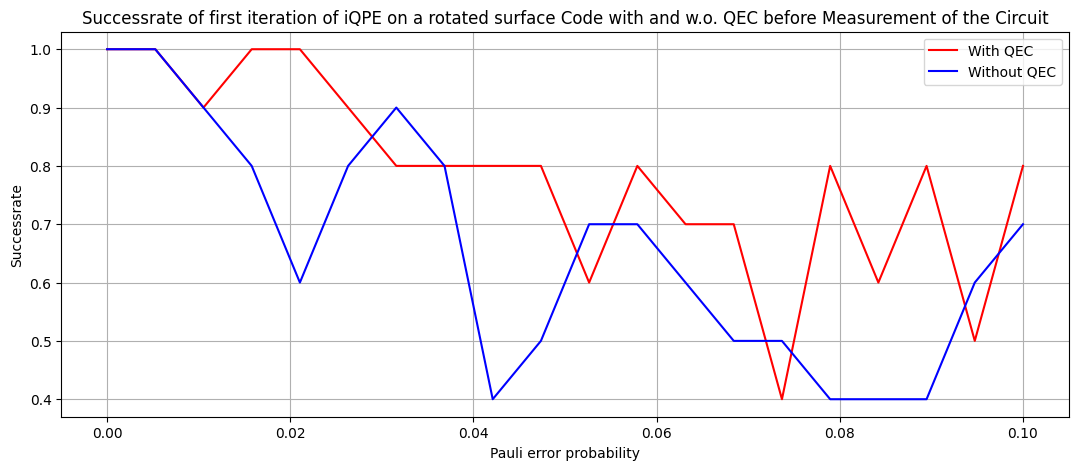

In [27]:
x = np.linspace(0,0.1,20)
y = []
y_no_QEC = []
shots = 10
for i in x:
    qc = rot_surf_code(2)

    X_L(qc, False, n = 1)
    H_L(qc, pos=0)
    control_Z_L(qc)
    H_L(qc ,pos=0)

    QEC(qc, pos= 0, hadamard=False, iterations = 1)

    zeros, ones = readout(qc, False, 0, shots, i)

    y.append(ones)
    ######################################## Nochmal aber ohne QEC
    qc = rot_surf_code(2)

    X_L(qc, False, n = 1)
    H_L(qc, pos=0)
    control_Z_L(qc)
    H_L(qc ,pos=0)

    zeros, ones = readout(qc, False, 0, shots, i)

    y_no_QEC.append(ones)

data = np.array((x,y,y_no_QEC))
#np.savetxt("QEC_50k_shots_Pauli_XZ_compare.txt", data, delimiter=",")

fig, ax = plt.subplots(figsize=(13,5))

ax.plot(x,y,label = "With QEC", color="red")
ax.plot(x,y_no_QEC, label = "Without QEC", color="blue")
plt.title("Successrate of first iteration of iQPE on a rotated surface Code with and w.o. QEC before Measurement of the Circuit")
plt.xlabel("Pauli error probability")
plt.ylabel("Successrate")
plt.grid()
plt.legend()
plt.show()

In [ ]:
shots = 100
x = np.linspace(0,0.05,20)
y = []
y_no_QEC = []
for i in x:
    # depolarizing_prob = i
    # dep_error = depolarizing_error(depolarizing_prob, 1)
    # dep_error_2q = depolarizing_error(depolarizing_prob, 2)         #"s","t","tdg","sdg"
    # noise_model = NoiseModel()
    # noise_model.add_all_qubit_quantum_error(dep_error, ['x',"z",'h'])  # Apply to single-qubit gates
    # noise_model.add_all_qubit_quantum_error(dep_error_2q, ["cx"])  # Apply to 2-qubit gates

    p = i
    p_error = pauli_error([["X",p/2],["I",1-p],["Z",p/2]])
    p_error_2 = pauli_error([["XX",p/6],["XI",p/6],["IX",p/6],["II",1-p],["ZZ",p/6],["ZI",p/6],["IZ",p/6]])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(p_error, ['x', "z", 'h'])  # Apply to single-qubit gates
    noise_model.add_all_qubit_quantum_error(p_error_2, ['cx'])  # Apply to 2-qubit gates

    
    rot_surf_code(2)
    ancilla = qc.num_qubits - 3
    X_L(qc, n = 1)
    H_L(qc, 0)

    #qc = control_S_L(qc,"10",control = 0, target = 1)

    T_L(qc, had=True, pos=0)
    T_L(qc, had=False, pos=1)

    QEC(qc, True, pos = 0, iterations=1)
    QEC(qc, False, pos = 1, iterations=1)

    CNOT(qc, hadamard="10",control=0)
    adj_T_L(qc,had=False,pos=1)
    CNOT(qc, hadamard="10",control=0)
    adj_S_L(qc, had=True, pos = 0)
    H_L(qc, 0)

    QEC(qc, False, pos = 0, iterations=1)

    qc.reset(ancilla)
    Z_parity(qc, pos = 0)

    qc.measure(ancilla,3)

    sim = AerSimulator()
    job = sim.run(qc, noise_model=noise_model, shots=shots)
    result = job.result()
    counts = result.get_counts()

    x_old = list(counts.keys())
    x_old = [j[0] for j in x_old]
    y_old = list(counts.values())

    success  =  0
    for j in range(len(x_old)):
        if x_old[j] == "0":
            success += y_old[j]
            
    Erfolgsrate = success/shots
    y.append(Erfolgsrate)
    ######################################## Nochmal aber ohne QEC
    qc = rot_surf_code(2)
    ancilla = qc.num_qubits - 3
    X_L(qc, n = 1)
    H_L(qc, 0)
    control_S_L(qc,"10",control = 0, target = 1)
    adj_S_L(qc, had=True, pos = 0)
    H_L(qc, 0)
    qc.reset(ancilla)
    Z_parity(qc, pos = 0)

    qc.measure(ancilla,3)
    
    sim = AerSimulator()
    job = sim.run(qc, noise_model = noise_model, shots=shots)
    result = job.result()
    counts = result.get_counts()

    x_old = list(counts.keys())
    x_old = [j[0] for j in x_old]
    y_old = list(counts.values())

    success  =  0
    for j in range(len(x_old)):
        if x_old[j] == "0":
            success += y_old[j]

    Erfolgsrate = success/shots
    y_no_QEC.append(Erfolgsrate)

data = np.array((x,y,y_no_QEC))
#np.savetxt("iQPE_2nd_step_7500_shots_ideal_magic_states_pauli_xz_new_5.txt", data, delimiter=",")

gates(qc)

fig, ax = plt.subplots(figsize=(13,5))

ax.plot(x,y,label = "With QEC", color="red", marker = "o")
ax.plot(x,y_no_QEC, label = "Without QEC", color="blue", marker = "o")
plt.title("Successrate of second Iteration of iQPE on a rotated surface Code with and w.o. QEC before Measurement of the Circuit")
plt.xlabel("Pauli error probability")
plt.ylabel("Successrate")
plt.grid()
plt.legend()
plt.show()